In [1]:
!git clone https://github.com/ubermenchh/my_fastai_part2.git
%cd my_fastai_part2

fatal: destination path 'my_fastai_part2' already exists and is not an empty directory.
/content/my_fastai_part2


In [2]:
!pip install -q datasets

# Autoencoders

In [3]:
import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
import fastcore.all as fc
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial

from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from datasets import load_dataset,load_dataset_builder

from fastprogress import progress_bar,master_bar
from miniai.datasets import *
from miniai.training import *
from miniai.conv import *

In [4]:
from fastcore.test import test_close

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray'

import logging
logging.disable(logging.WARNING)

## Data

In [5]:
x, y = 'image', 'label'
name = 'fashion_mnist'
dsd = load_dataset(name, ignore_verifications=True)

/usr/local/lib/python3.10/dist-packages/datasets/load.py:1748: FutureWarning: 'ignore_verifications' was deprecated in favor of 'verification_mode' in version 2.9.1 and will be removed in 3.0.0.
You can remove this warning by passing 'verification_mode=no_checks' instead.
  warnings.warn(


  0%|          | 0/2 [00:00<?, ?it/s]

In [6]:
@inplace
def transformi(b): b[x] = [TF.to_tensor(o) for o in b[x]]

In [7]:
bs = 256
tds = dsd.with_transform(transformi)

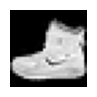

In [8]:
ds = tds['train']
img = ds[0]['image']
show_image(img, figsize=(1, 1));

In [9]:
cf = collate_dict(ds)

In [10]:
def collate_(b): return to_device(cf(b))
def data_loaders(dsd, bs, **kwargs):
    return {k:DataLoader(v, bs, **kwargs) for k, v in dsd.items()}

In [11]:
dls = data_loaders(tds, bs, collate_fn=collate_)

In [12]:
dt = dls['train']
dv = dls['test']

xb, yb = next(iter(dt))

In [13]:
labels = ds.features[y].names

In [14]:
labels

['T - shirt / top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [15]:
lbl_getter = itemgetter(*yb[:16])
titles = lbl_getter(labels)

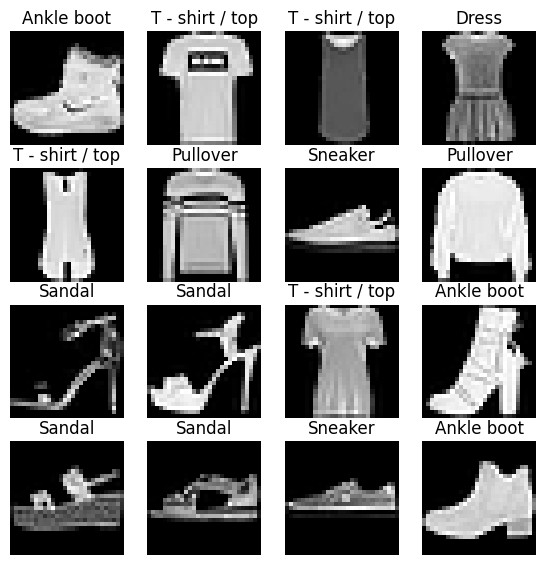

In [16]:
mpl.rcParams['figure.dpi'] = 100
show_images(xb[:16], imsize=1.7, titles=titles)

## Classify

In [17]:
from torch import optim

In [18]:
bs = 256
lr = 0.4

In [19]:
cnn = nn.Sequential(
    conv(1, 4),             # 14x14
    conv(4, 8),             # 7x7
    conv(8, 16),            # 4x4
    conv(16, 16),           # 2x2
    conv(16, 10, act=False),
    nn.Flatten()
).to(def_device)

In [20]:
opt = optim.SGD(cnn.parameters(), lr=lr)
loss, acc = fit(5, cnn, F.cross_entropy, opt, dt, dv)

0 0.746326738834381 0.7322
1 0.5422051578521728 0.8115
2 0.471528151845932 0.8362
3 0.44919379682540894 0.8432
4 0.43685541505813597 0.8496


In [21]:
dsd['train'][0]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28 at 0x7F87A1430D30>,
 'label': 9}

## Autoencoders

In [22]:
def deconv(ni, nf, ks=3, act=True):
    layers = [nn.UpsamplingNearest2d(scale_factor=2),
              nn.Conv2d(ni, nf, stride=1, kernel_size=ks, padding=ks//2)]
    if act: layers.append(nn.ReLU())
    return nn.Sequential(*layers)

### `deconv`
- constructs a sequential neural network module for performing deconvolution.
- `layers` variable has two layers:
    - `nn.UpsamplingNearest2d`, which performs nearest-neighbot upsampling of the input tensor by a scale factor. This helps in upsampling the resolution of the feature maps.
    - `nn.Con2d`, performs 2D convolution on the input tensor. The padding here ensures that the output has the same spatial dimensions as the input.
- If the `act` flag is `True`, `nn.ReLU()` is appended to the `layers` list, which applies the rectified linear unit activation function to the output of the convolution.
- Function returns a sequential container (`nn.Sequential`) that consists of the layers defined in the `layers` list.
- `*` operator is used to unpack the `layers` list as individual arguments to the `nn.Sequential` constructor.

In [23]:
p = torch.arange(1, 5, dtype=torch.float32).view(1,1,2,2)
up = nn.UpsamplingNearest2d(scale_factor=2)
p, up(p)

(tensor([[[[1., 2.],
           [3., 4.]]]]),
 tensor([[[[1., 1., 2., 2.],
           [1., 1., 2., 2.],
           [3., 3., 4., 4.],
           [3., 3., 4., 4.]]]]))

In [24]:
def eval(model, loss_func, valid_dl, epoch=0):
    model.eval()
    with torch.no_grad():
        tot_loss, count = 0., 0
        for xb, _ in valid_dl:
            pred = model(xb)
            n = len(xb)
            count += n
            tot_loss += loss_func(pred, xb).item() * n
    print(epoch, f'{tot_loss / count:.3f}')

In [25]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb, _ in train_dl:
            loss = loss_func(model(xb), xb)
            loss.backward()
            opt.step()
            opt.zero_grad()
        eval(model, loss_func, valid_dl, epoch)

In [36]:
ae = nn.Sequential(             # 28x28
    nn.ZeroPad2d(2),            # 32x32
    conv(1, 2),                 # 16x16
    conv(2, 4),                 # 8x8
    # conv(4, 8),
    # deconv(8, 4),
                                deconv(4, 2),                 # 16x16
    deconv(2, 1, act=False),      # 32x32
    nn.ZeroPad2d(-2),           # 28x28
    nn.Sigmoid()
).to(def_device)

In [37]:
eval(ae, F.mse_loss, dv)

0 0.203


In [38]:
opt = optim.SGD(ae.parameters(), lr=0.04)
fit(10, ae, F.mse_loss, opt, dt, dv)

0 0.107
1 0.064
2 0.046
3 0.038
4 0.034
5 0.032
6 0.031
7 0.030
8 0.029
9 0.028


In [43]:
opt = optim.SGD(ae.parameters(), lr=0.01)
fit(10, ae, F.mse_loss, opt, dt, dv)

0 0.018
1 0.018
2 0.018
3 0.018
4 0.018
5 0.018
6 0.018
7 0.018
8 0.018
9 0.018


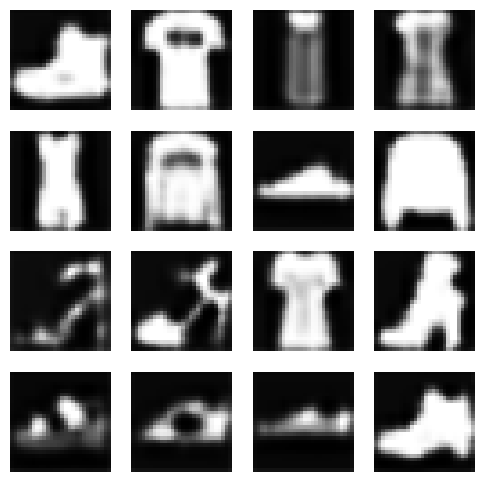

In [44]:
p = ae(xb)
show_images(p[:16].data.cpu(), imsize=1.5)

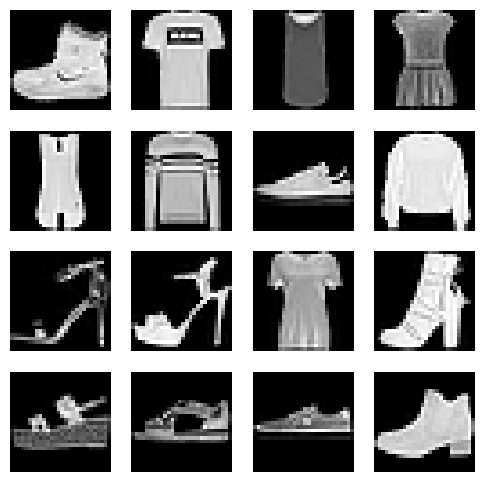

In [45]:
show_images(xb[:16].data.cpu(), imsize=1.5)